In [1]:
from cities.deployment.tracts_minneapolis.predict_new import TractsModelPredictor

from cities.utils.plot_ts import (plot_coefs, summarize_time_series,
                                  plot_model_summary)

from cities.utils.data_loader import db_connection
import time
import torch
import pyro


import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
start = time.time()
with db_connection() as conn:
    predictor = TractsModelPredictor(conn)

end = time.time()
print("Time elapsed:", end - start)

Time elapsed: 3.307415246963501


In [3]:
predictor.train_model(override=True, num_steps=55)

reshape parents
reshape categoricals
reshaping_outcome
False
using reshaped parents
False
using reshaped parents
[iteration 0001] loss: 17350.1543
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using 

In [4]:
factual_intervention = {"radius_blue": 106.7, "limit_blue": 0, "radius_yellow_line": 402.3, "radius_yellow_stop": 804.7, "limit_yellow": 0.5, "reform_year": 2015}
extreme_intervention = {"radius_blue": 1450, "limit_blue": 0, "radius_yellow_line": 2640, "radius_yellow_stop": 2640, "limit_yellow": 0.3, "reform_year": 2012}


with db_connection() as conn:
    predictor = TractsModelPredictor(conn)
    factual_intervention = predictor._tracts_intervention(conn, **factual_intervention)
    extreme_intervention = predictor._tracts_intervention(conn, **extreme_intervention)


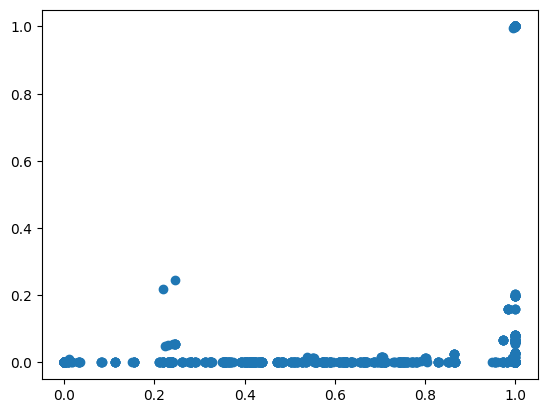

In [5]:
actual_limit = predictor.nonified_data['continuous']['mean_limit_original']


#plt.scatter(actual_limit, factual_intervention)

plt.scatter(actual_limit, extreme_intervention)

reshape parents
reshape categoricals
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False


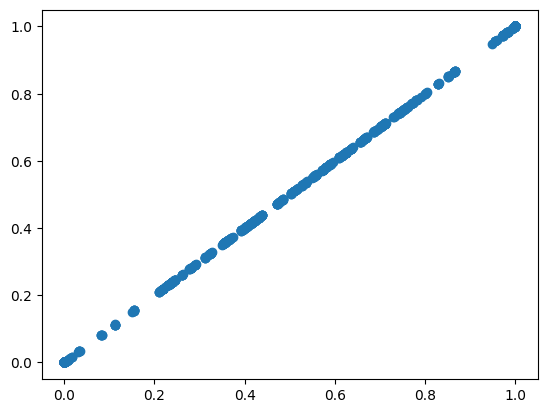

In [6]:
predictor.clear_reshaped_model_data()
samples =  predictor.predictive(predictor.nonified_data, 
                                force_ts_reshape = False)

sample_limit = samples['limit'][1,0,:]
actual_limit.shape

assert torch.all(samples['limit'][1,0,:] == samples['limit'][0,0,:])
assert torch.all(samples['limit'][1,0,:] == actual_limit)
#assert sample_limit.shape == actual_limit.shape

print(
samples.keys()
)
plt.scatter(actual_limit, sample_limit)

reshape parents
reshape categoricals
True
reshape parents
reshape categoricals
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped p

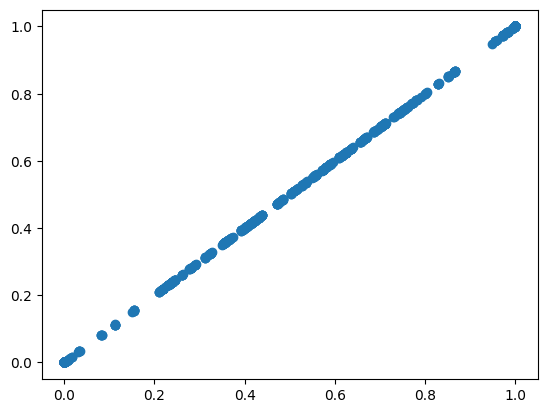

In [8]:
from chirho.interventional.handlers import do
from chirho.counterfactual.handlers import MultiWorldCounterfactual


predictor.clear_reshaped_model_data()
with MultiWorldCounterfactual() as mwc:
    with do(actions = {"limit": factual_intervention}):
        samples =  predictor.predictive(predictor.nonified_data, 
                                        )


assert torch.allclose(samples['limit'][1,0,:], actual_limit)

plt.scatter(samples['limit'][0,0,0,0,0, 0, :], samples['limit'][0,0,1,0,0, 0, :])
plt.show()



reshape parents
reshape categoricals
True
reshape parents
reshape categoricals
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped parents
False
using reshaped p

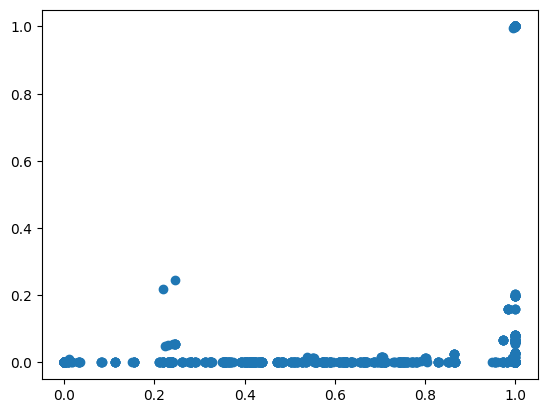

torch.Size([100, 1, 2, 1, 1, 1, 1130])
torch.Size([100, 113, 1])


torch.Size([100, 1, 1, 2, 10, 1, 1, 113, 1])

In [9]:
predictor.clear_reshaped_model_data()
with MultiWorldCounterfactual() as mwc:
    with do(actions = {"limit": extreme_intervention}):
        samples =  predictor.predictive(predictor.nonified_data, 
                                       )


#assert torch.allclose(samples['limit'][1,0,:], actual_limit)

plt.scatter(samples['limit'][0,0,0,0,0, 0, :], samples['limit'][0,0,1,0,0, 0, :])
plt.show()

print(samples['limit'].shape)
print(samples['y_0'].shape)
samples['predicted_housing_units_cumulative'].shape

In [ ]:

limit_intervention = predictor._tracts_intervention(conn, **intervention)

In [ ]:
#    result_factual = predictor.predict_cumulative(conn, intervention=factual_intervention)
#    #result_extreme = predictor.predict_cumulative(conn, intervention=extreme_intervention)



In [5]:
factual = result_factual['all_samples']




/home/rafal/s78projects/cities/cities/utils/plot_ts.py:219: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


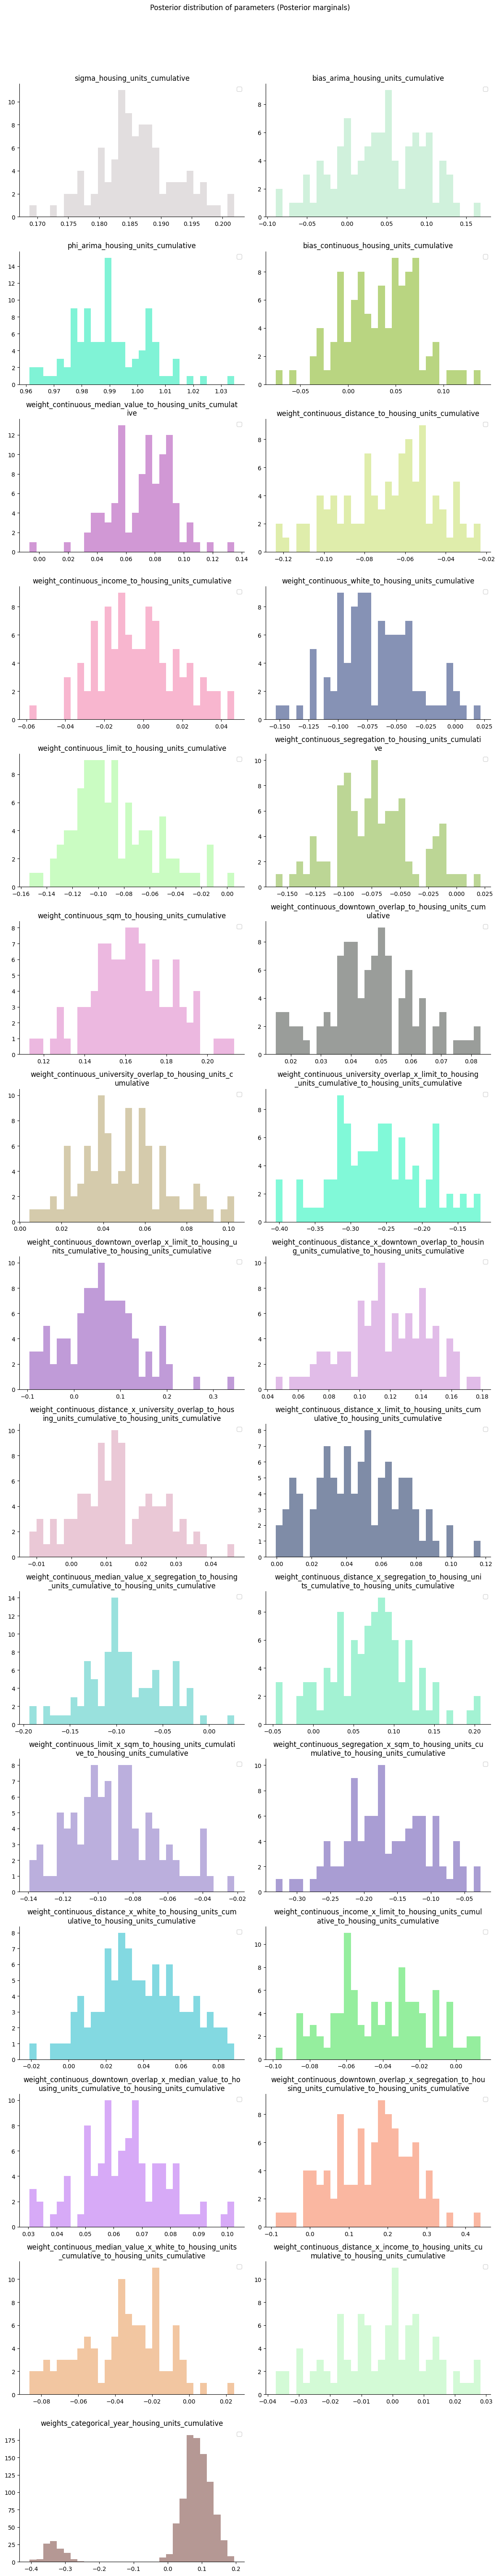

In [6]:
specific_names = ['sigma_housing_units_cumulative', 'bias_arima_housing_units_cumulative', 'phi_arima_housing_units_cumulative', 'bias_continuous_housing_units_cumulative']
weigth_names = [name for name in factual.keys() if name.startswith("weight")]
param_sites = specific_names + weigth_names

assert all(name in factual.keys() for name in param_sites)

plot_coefs(factual, param_sites, true_params=None, title="Posterior marginals")

In [11]:

y_true = predictor.data['reshaped']['continuous']['housing_units_cumulative']

factual['limit'].shape
#summary = summarize_time_series(samples, y_true, y_site="predicted_housing_units_cumulative")
#plot_model_summary(summary, y_true, waic=waic, title="posterior predictive check", 
#                   path = "cumulative model evaluation.png")

torch.Size([100, 1, 2, 1, 1, 1, 1130])